In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.2.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSSWORT/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSSWORT/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteSSWORT/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

print(training_sentences[0])
print(training_labels[:5])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
[0, 0, 0, 1, 1]


In [20]:
print(len(training_sentences))
print(len(testing_labels_final))

25000
25000


In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 120 #  So if they are shorter than that there'll be padded. If there longer than that they'll be truncated.
trunc_type='post'# so we'll cut off the back of the review and not the front, 
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) # We'll now fit the tokenizer on our training set of data.
word_index = tokenizer.word_index # Once we have our word index, we can now replace the strings containing the words with the token value we created for them. 

sequences = tokenizer.texts_to_sequences(training_sentences)# This will be the list called sequences.
# As before, the sentences will have variant length. So we'll pad and or truncate the sequenced sentences until they're all the same length, determined by the maxlength parameter.
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Then we'll do the same for the testing sequences. 
# Do note that the testing sequences are tokenized based on the word index that was learned from the training words. 
# So you may find a lot more OOVs, in the testing sequence than you would have in the training sequence,
# because there'll be a lot of words that it hasn't encountered.
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [17]:
# To be able to plot it, we need a helper function to reverse our word index. As it currently stands, 
# our word index has the key being the word, and the value being the token for the word. We'll need to flip this around,
# We'll need to flip this around, to look through the padded list to decode the tokens back into the words, 
# so we've written this helper function.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [9]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # 词嵌入，通过向量表示一个词
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')# 用1 表示只有2类
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # 词嵌入，通过向量表示一个词 每句120个词，每词16嵌入
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 10
model.fit(padded, 
          training_labels_final, 
          epochs=num_epochs, 
          validation_data=(testing_padded, testing_labels_final))
# looks like overfitting

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4966 - accuracy: 0.7432 - val_loss: 0.3472 - val_accuracy: 0.8483
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2469 - accuracy: 0.9036 - val_loss: 0.3645 - val_accuracy: 0.8414
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1010 - accuracy: 0.9746 - val_loss: 0.4461 - val_accuracy: 0.8241
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0272 - accuracy: 0.9965 - val_loss: 0.5297 - val_accuracy: 0.8227
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0085 - accuracy: 0.9991 - val_loss: 0.5804 - val_accuracy: 0.8233
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.6372 - val_accuracy: 0.8239
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6841 - val_accuracy: 0.8240
Epoch 

In [12]:
# We'll start by getting the results of the embeddings layer, which is layer zero. We can get the weights, and print out their shape like this.
e = model.layers[0] # Embedding
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
# We can see that this is a 10,000 by 16 array, we have 10,000 words in our corpus, and we're working in a 16 dimensional array, so our embedding will have that shape.

(10000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  # To the metadata array, we just write out the words. 
  out_m.write(word + "\n")
  # To the vectors file, we simply write out the value of each of the items in the array of embeddings
  # i.e, the co-efficient of each dimension on the vector for this word.
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n") 
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

  # Next go to projector.tensorflow.org to find the 

In [15]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences(sentence)
print(sequence)

[[11], [], [1431], [966], [4], [1537], [1537], [4715], [], [790], [2019], [11], [2929], [2184], [], [790], [2019], [11], [579], [], [11], [579], [], [4], [1782], [4], [4517], [11], [2929], [1275], [], [], [2019], [1003], [2929], [966], [579], [790], []]


In [0]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [0]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -o /tmp/sarcasm.json

In [0]:
with open('/tmp/sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# if fails, run 
# !pip install -q tensorflow-datasets
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteG44X5H/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteG44X5H/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteG44X5H/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_data, test_data = imdb['train'], imdb['test']
train_data = train_data.map(lambda x_text, x_label: (x_text, tf.expand_dims(x_label, -1)))
test_data = test_data.map(lambda x_text, x_label: (x_text, tf.expand_dims(x_label, -1)))

In [3]:
tokenizer = info.features['text'].encoder
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [4]:
sample_string = 'tensorflow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print(tokenized_string)

original_string = tokenizer.decode(tokenized_string)
print(original_string)

[943, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
tensorflow, from basics to mastery


In [5]:

# Note that this is case sensitive and punctuation is maintained unlike the tokenizer 
# based on subwords, build by subwords8k vocabulary
for ts in tokenized_string:
  print(ts, tokenizer.decode([ts]))

943 ten
2327 sor
2934 flow
2 , 
48 from 
4249 basi
4429 cs 
7 to 
2652 master
8050 y


In [6]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim), # 词嵌入，通过向量表示一个词
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')# 用1 表示只有2类
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(train_data, 
          epochs=num_epochs, 
          validation_data=test_data)

Epoch 1/10
25000/25000 [==============================] - 244s 10ms/step - loss: 0.6867 - accuracy: 0.5296 - val_loss: 0.6868 - val_accuracy: 0.5293
Epoch 2/10
25000/25000 [==============================] - 244s 10ms/step - loss: 0.6846 - accuracy: 0.5375 - val_loss: 0.6862 - val_accuracy: 0.5346
Epoch 3/10
25000/25000 [==============================] - 245s 10ms/step - loss: 0.6834 - accuracy: 0.5414 - val_loss: 0.6856 - val_accuracy: 0.5371
Epoch 4/10
25000/25000 [==============================] - 244s 10ms/step - loss: 0.6825 - accuracy: 0.5438 - val_loss: 0.6856 - val_accuracy: 0.5381
Epoch 5/10
25000/25000 [==============================] - 243s 10ms/step - loss: 0.6819 - accuracy: 0.5449 - val_loss: 0.6858 - val_accuracy: 0.5385
Epoch 6/10
25000/25000 [==============================] - 245s 10ms/step - loss: 0.6815 - accuracy: 0.5463 - val_loss: 0.6861 - val_accuracy: 0.5379
Epoch 7/10
25000/25000 [==============================] - 250s 10ms/step - loss: 0.6812 - accuracy: 0.5469

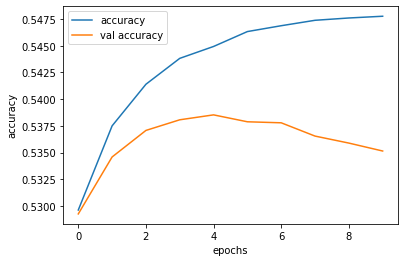

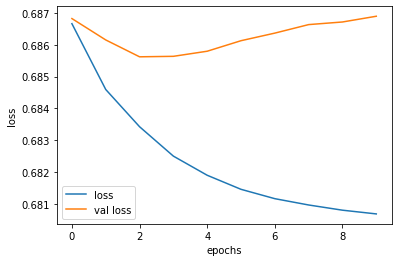

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val '+string])
  plt.show()

plot_graphs(model.history, 'accuracy')
plot_graphs(model.history,'loss')



In [13]:
model.history